# **importing Libraries**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

# **Load Data**

In [21]:
data = pd.read_csv("/content/Mall_Customers.csv")

# **Show Data**

In [22]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# **Data Pre-processing**

**checking nulls**

In [23]:
data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


**Display the data types of each column**

In [24]:
data.dtypes

,0
CustomerID,int64
Gender,object
Age,int64
Annual Income (k$),int64
Spending Score (1-100),int64


**Drop the 'CustomerID' column as it's not needed for clustering**

In [25]:
data = data.drop(columns=['CustomerID'])

**Plot the distribution of 'Annual Income (k$)'**

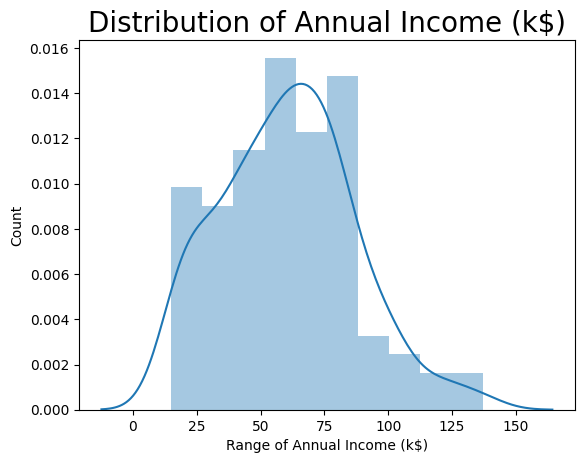

In [26]:
sns.distplot(data['Annual Income (k$)'])
plt.title('Distribution of Annual Income (k$)', fontsize=20)
plt.xlabel('Range of Annual Income (k$)')
plt.ylabel('Count')
plt.show()

**Plot the distribution of 'Spending Score (1-100)'**

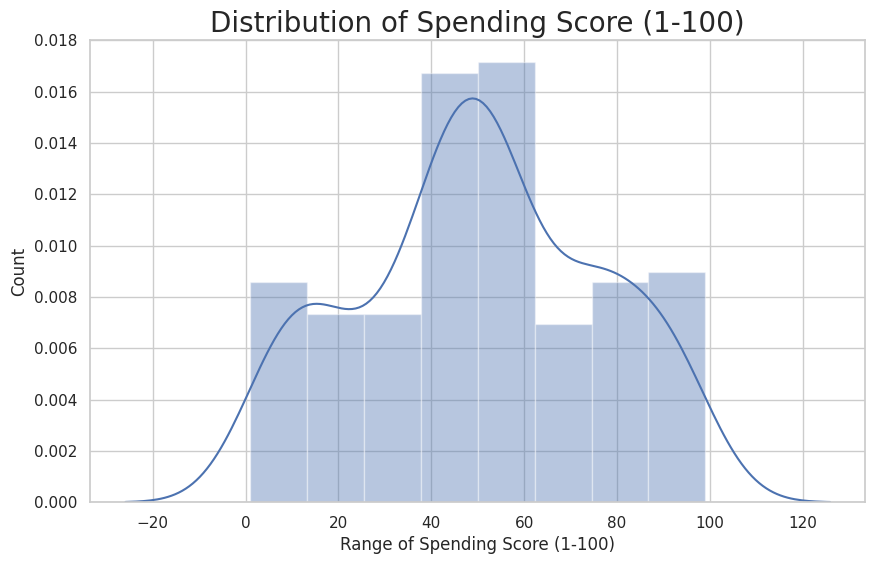

In [27]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.distplot(data['Spending Score (1-100)'])
plt.title('Distribution of Spending Score (1-100)', fontsize=20)
plt.xlabel('Range of Spending Score (1-100)')
plt.ylabel('Count')
plt.show()

**Plot the count of each gender**

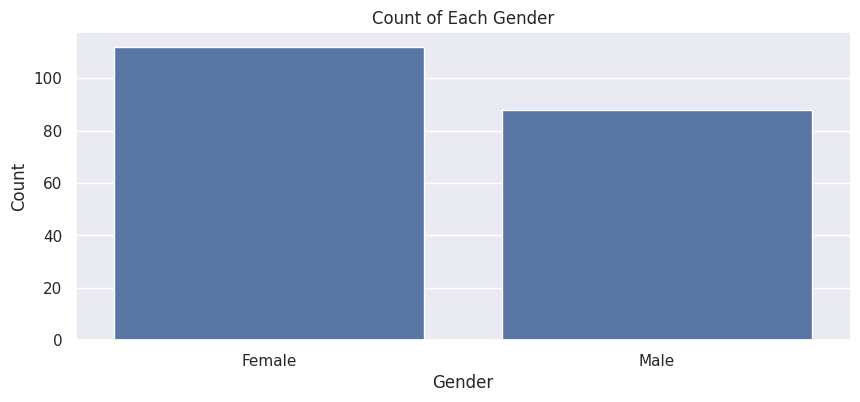

In [28]:
genders = data.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
sns.barplot(x=genders.index, y=genders.values)
plt.title('Count of Each Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

**Encode the 'Gender' column from categorical to numerical**

In [29]:
encoder = LabelEncoder()
data['Gender'] = encoder.fit_transform(data["Gender"])

**Calculate the Interquartile Range (IQR) for outlier detection**

In [30]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

**Identify outliers**

In [31]:
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_indices = data[outliers].index

**Drop outliers from the dataset**

In [32]:
clean_data = data.drop(outlier_indices)

**Display the cleaned data**

In [33]:
clean_data

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
193,0,38,113,91
194,0,47,120,16
195,0,35,120,79
196,0,45,126,28


**
# Plot box plots to visualize the distribution and detect remaining outliers**

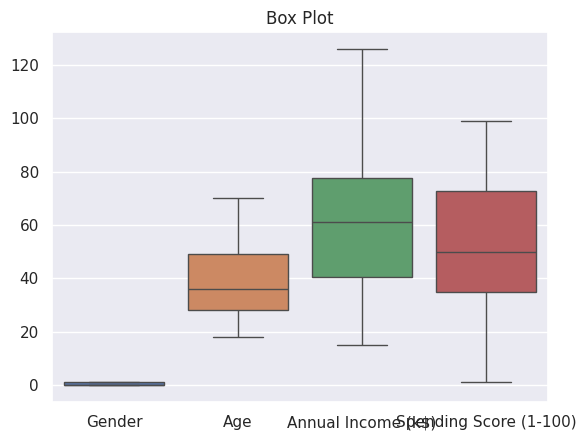

In [35]:
sns.boxplot(clean_data)
plt.title('Box Plot')
plt.show()

**Standardize the features for better clustering performance**

In [36]:
scaler = StandardScaler()
clean_data[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(
    clean_data[['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
)

**Perform PCA to reduce the dimensionality to 2 components**

In [37]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(clean_data)
clean_data['PCA1'] = pca_components[:, 0]
clean_data['PCA2'] = pca_components[:, 1]


**Create a new DataFrame with PCA components**

In [38]:
df1 = clean_data[['PCA1', 'PCA2']]

**Function to determine the optimal number of clusters using the Elbow Method**

In [40]:
def optimum_k(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.title('Elbow Method for Optimal k')
    plt.show()


**Determine the optimal number of clusters (try up to 10)**

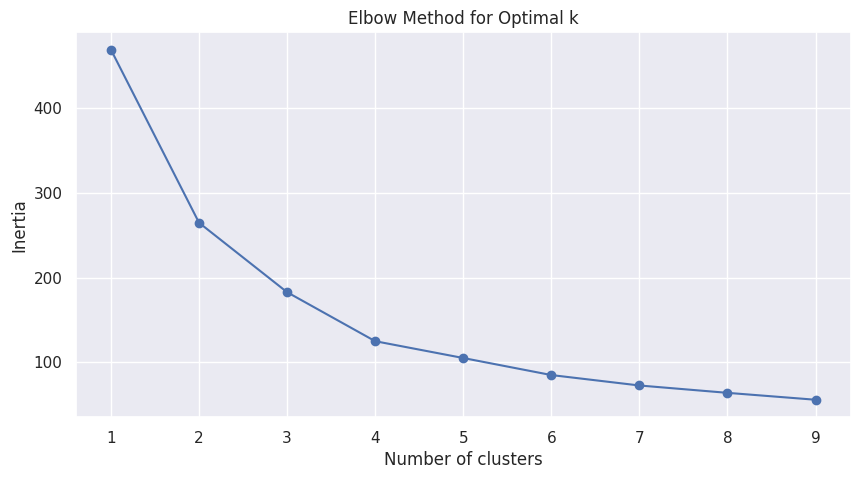

In [41]:
optimum_k(df1, 10)

**Perform K-Means clustering with 6 clusters**

In [42]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(df1)
y = kmeans.predict(df1)
df1["label"] = y

**Display the DataFrame with cluster labels**

In [43]:
df1.head()

,PCA1,PCA2,label
0,-0.409677,-0.854725,5
1,-1.429194,-0.665974,4
2,0.019003,-2.031137,5
3,-1.723179,-1.710059,4
4,-0.345276,-1.894094,5


**Calculate and display the silhouette score for the clustering**

In [44]:
silhouette_avg = silhouette_score(df1, y)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6168547230966662


**Plot the clusters in PCA-reduced space**

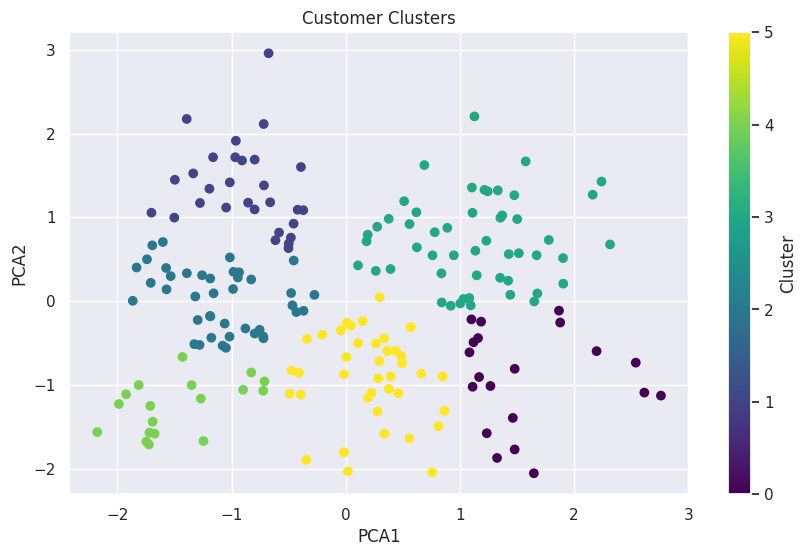

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['PCA1'], clean_data['PCA2'], c=y, cmap='viridis', marker='o')
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()

**Perform K-Means clustering with 5 clusters (alternative)**

In [46]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df1)
y = kmeans.predict(df1)
df1["label"] = y

**Display the DataFrame with updated cluster labels**

In [47]:
df1.head()

,PCA1,PCA2,label
0,-0.409677,-0.854725,2
1,-1.429194,-0.665974,4
2,0.019003,-2.031137,2
3,-1.723179,-1.710059,4
4,-0.345276,-1.894094,2


**Calculate and display the silhouette score for the clustering**

In [48]:
silhouette_avg = silhouette_score(df1, y)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5177326842030138


**Plot the clusters in PCA-reduced space with 5 clusters**

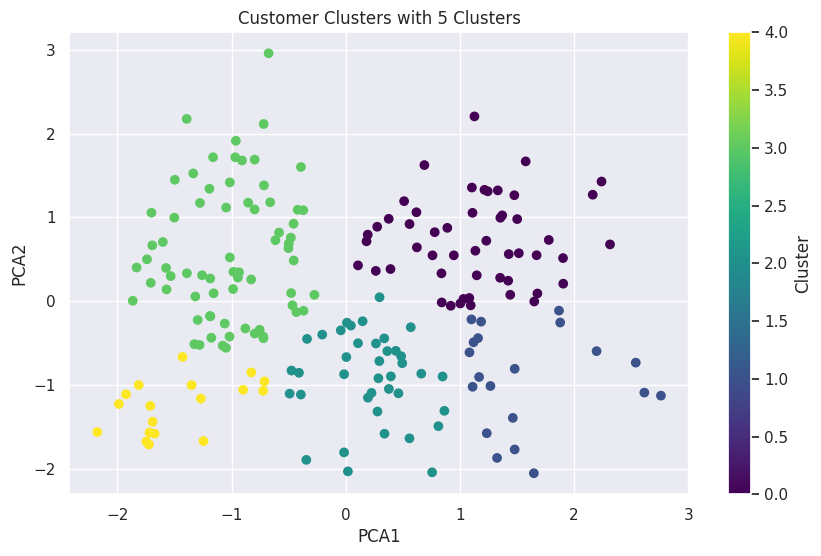

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['PCA1'], clean_data['PCA2'], c=y, cmap='viridis', marker='o')
plt.title('Customer Clusters with 5 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()